In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import sys


In [2]:
def load_img(img,size=(300,300)):
    im = Image.open(img)
    im = im.resize((size[0],size[1]),Image.ANTIALIAS)
    im = np.array(im)
    plt.imshow(im)
    plt.show()
    im = np.moveaxis(im,2,0)
    im = np.mean(im,axis=0)/255
    im = im[np.newaxis,np.newaxis,:,:]
    return im

## Group connected items

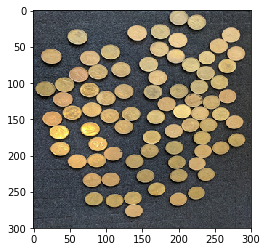

HBox(children=(IntProgress(value=0, max=300), HTML(value='')))

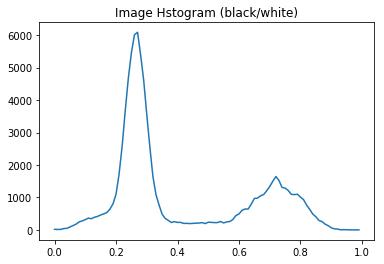

In [3]:
from visTools_v2.core_functions.operations.recursive_connected_components import connect,collect_masks
sys.setrecursionlimit(15000)

im = load_img('img/coins1.jpg')
labelled = connect(im,plot=True)

In [4]:
masks = collect_masks(labelled)

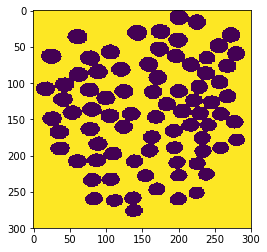

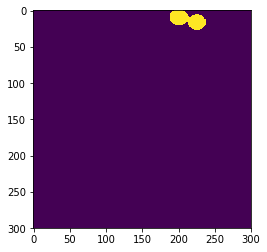

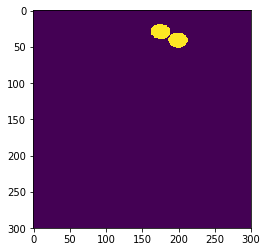

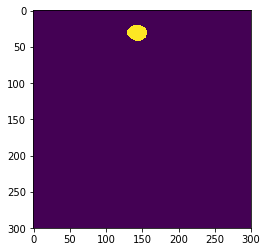

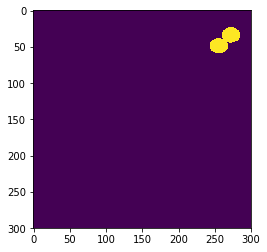

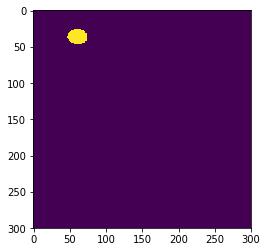

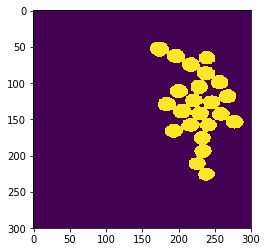

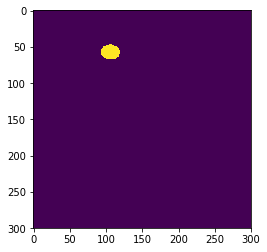

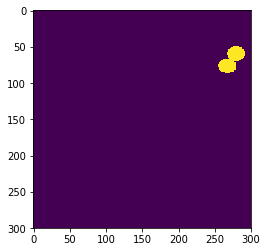

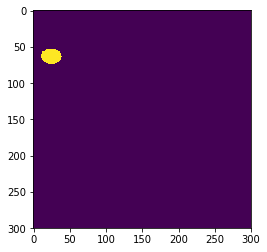

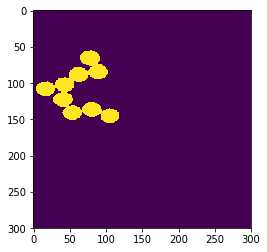

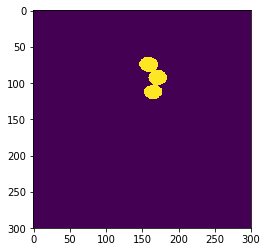

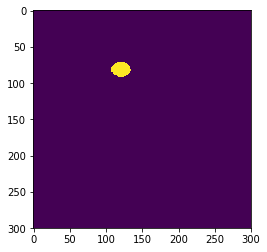

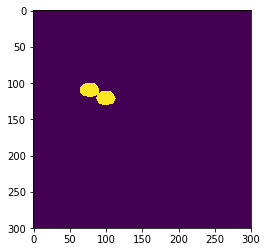

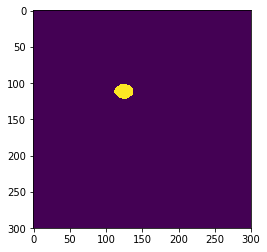

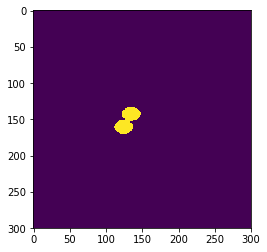

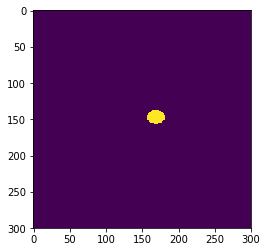

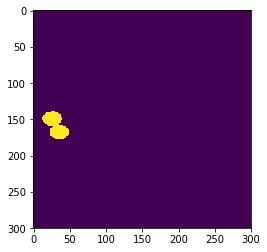

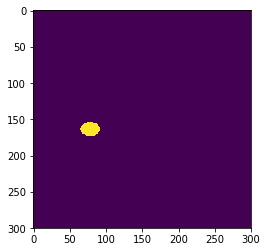

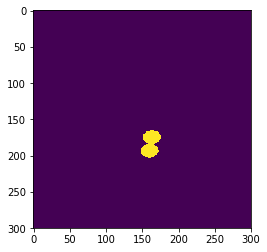

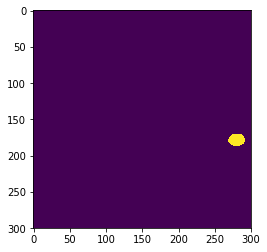

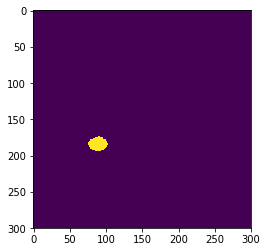

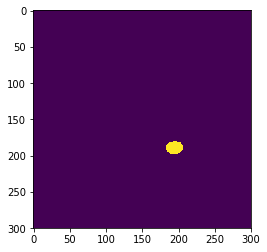

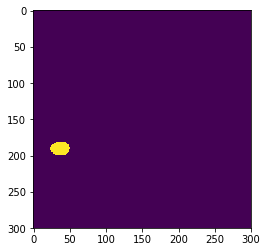

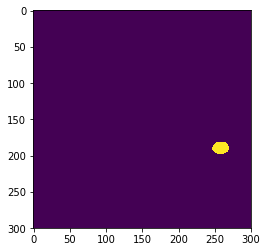

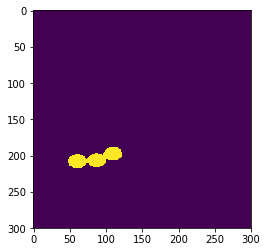

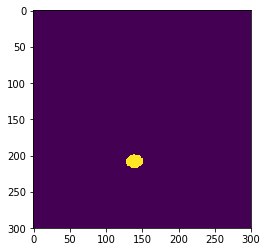

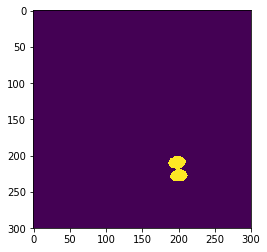

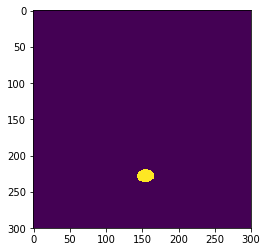

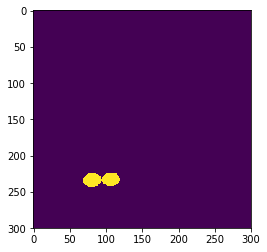

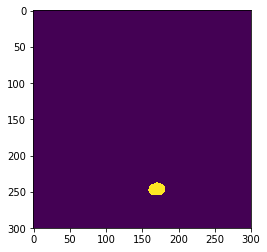

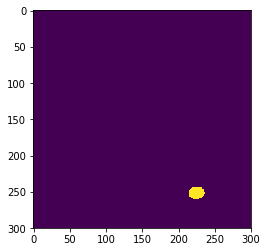

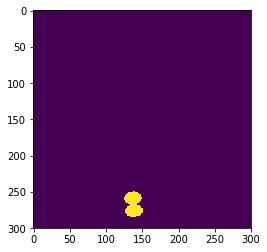

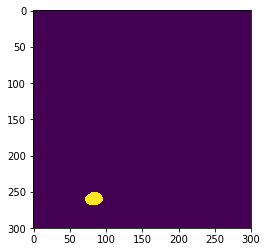

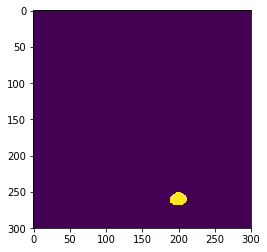

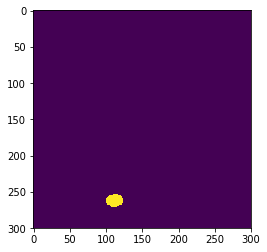

In [5]:
for i in range(len(masks)):
    plt.imshow(masks[i])
    plt.show()

## Extract img gradients

In [6]:
from visTools_v2.core_functions.edges import canny

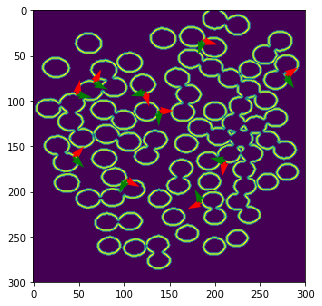

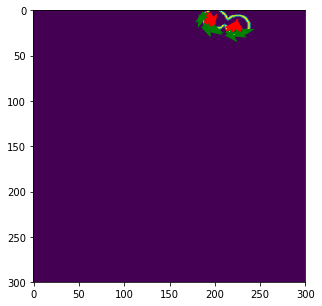

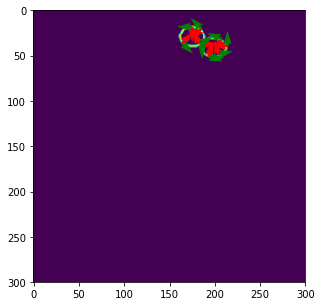

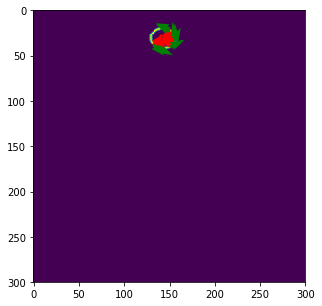

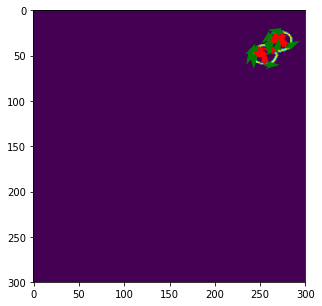

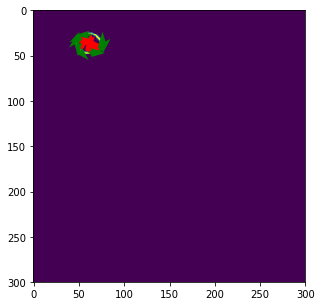

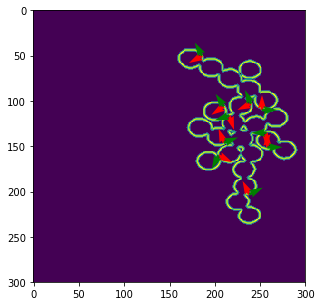

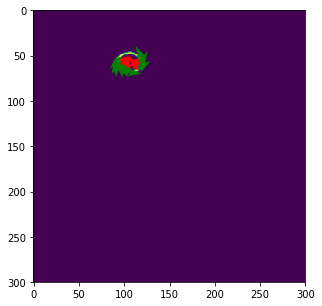

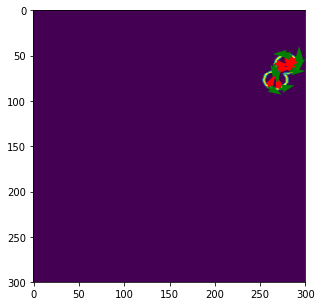

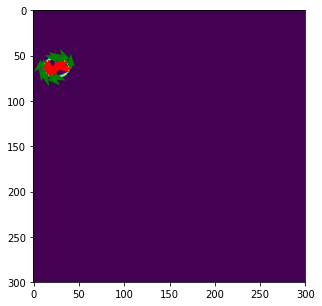

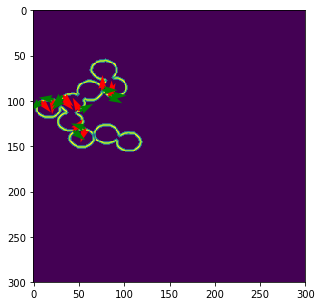

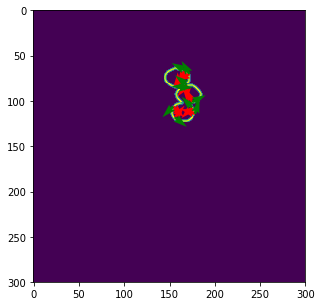

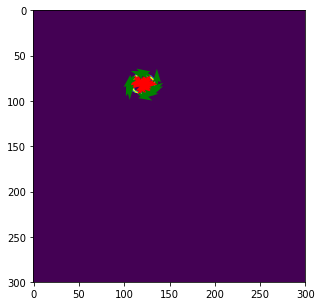

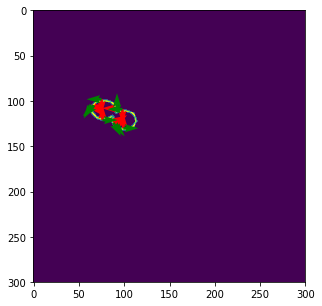

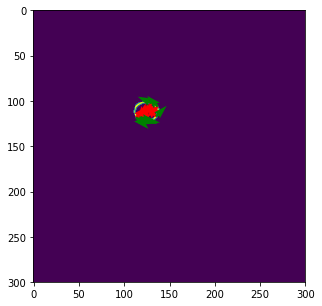

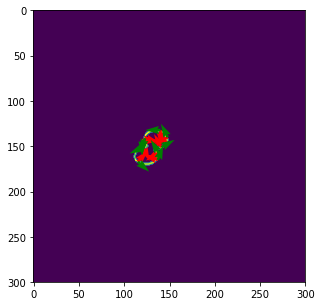

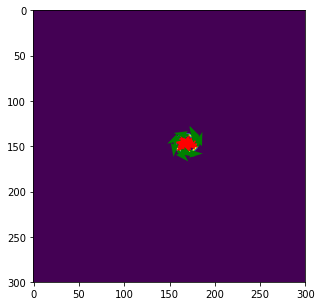

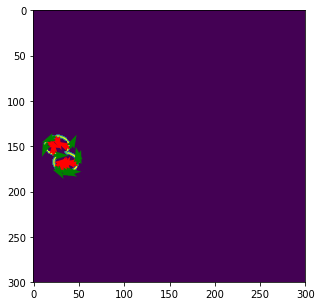

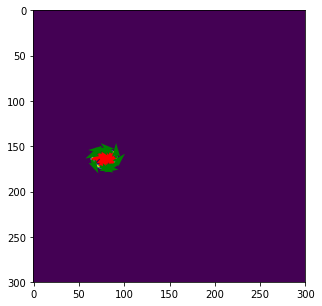

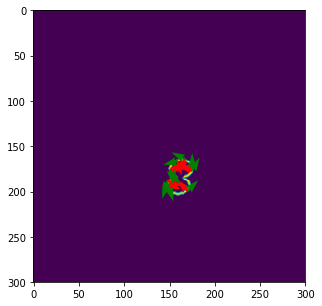

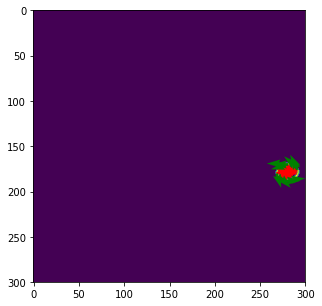

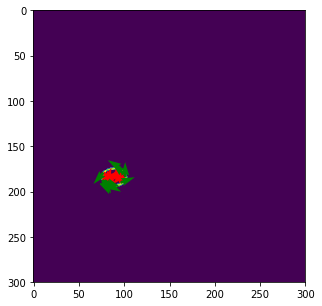

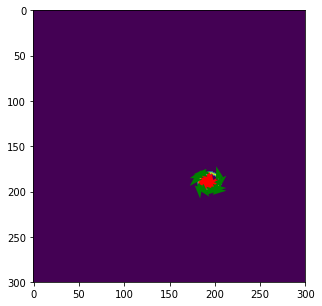

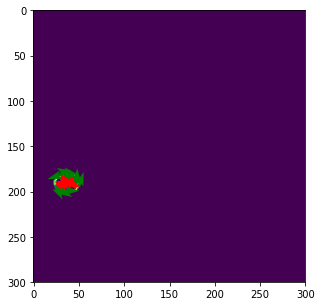

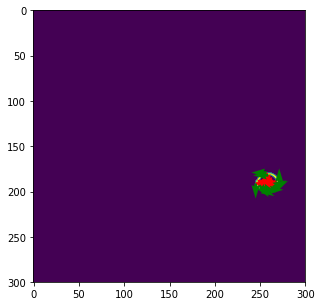

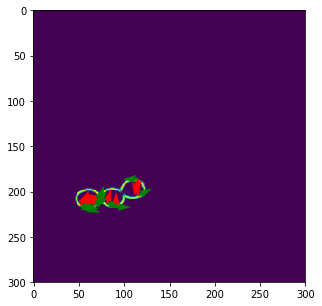

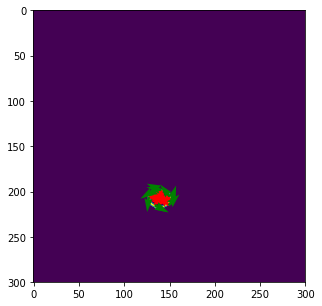

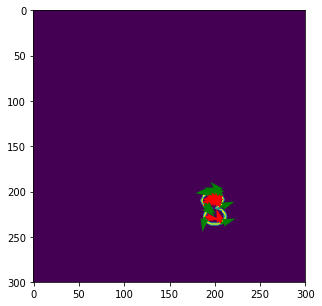

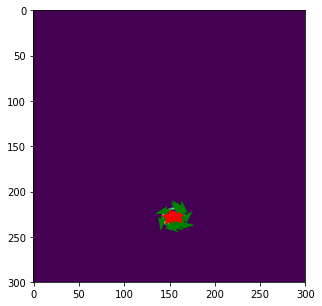

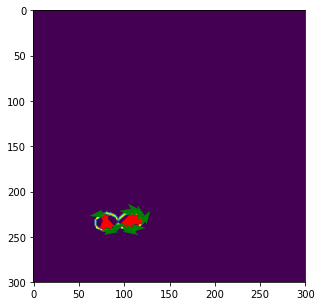

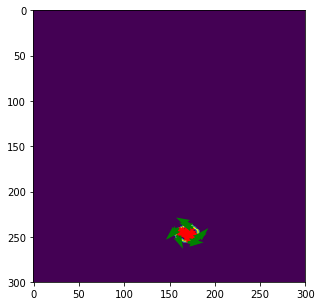

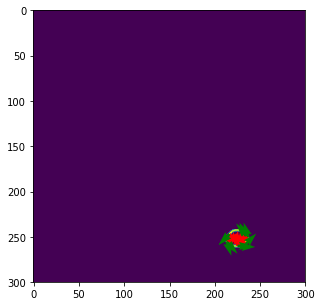

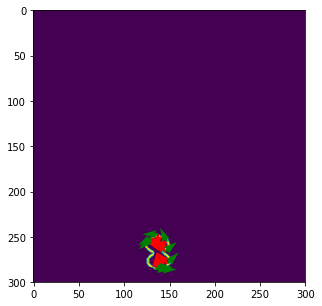

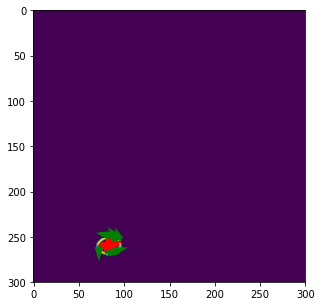

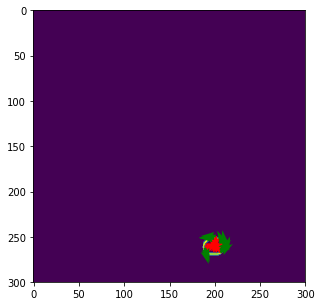

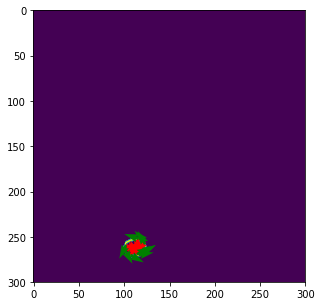

In [7]:
edgels = canny()
S = []
n = []
for i in range(len(masks)):  
    edgels = canny(h=3,w=3,th=.1)
    edgels.fit(1*masks[i][np.newaxis,np.newaxis,:,:],nonMaxSup=False)
    S.append(edgels.S)
    n.append(edgels.n)
    edgels.vector_field(figsize=(5,5),tan=True)
    plt.imshow(edgels.S)
    plt.show()

# Robust fitting

In [8]:
def circle_params(p):
    A,D,E,F = p
    xc = -D/(2*A)
    yc = -E/(2*A)
    R = np.sqrt(xc**2+yc**2-F/A)
    return R,np.array([xc,yc])
def circle_params_from_cart(xc,R):
    x,y = xc
    D = -2*x
    E = -2*y
    A = 1
    F = x**2+y**2-R**2
   
    return np.array([A,D,E,F])

def plot_circle_from_xk(xk,c='b'):
    plt.scatter(xk[1,:],xk[0,:],c=c,s=0.5)
    pass

def plot_circle_from_params(p,c='r'):
    R,xc = circle_params(p)
    teta = np.arange(0,2*np.pi,np.pi/36)
    xk = np.array([R*np.cos(teta),R*np.sin(teta)]) + xc[:,np.newaxis]
    plt.scatter(xk[0,:],xk[1,:],c=c,s=5)
    pass
    
def build_circle(R,xc,std=0,outliers=False,c='b',outliers_ratio=0.05,plot=True):
    noise = None
    
    teta = np.arange(0,2*np.pi,np.pi/36)
    xk = np.array([R*np.cos(teta),R*np.sin(teta)]) + xc[:,np.newaxis] + np.random.normal(0,std,(2,2*36))    
    
    if plot:plot_circle_from_xk(xk,c)
    if outliers:
        noise = np.array([0.5*R*np.cos(teta),0.5*R*np.sin(teta)]) + 0.5*R*xc[:,np.newaxis] + np.random.normal(0,std,(2,2*36))    
        #noise = np.random.normal(0,std,(2,int(outliers_ratio*72))) +2*xc[:,np.newaxis]+R
        if plot:plt.scatter(noise[0,:],noise[1,:],c='b')
        xk = np.hstack((xk,noise))
    return xk

In [9]:
import random
class random_cirles_from_edgels:
    def __init__(self,mask,n,th,lamb=10,ratio=(1,1)):
        self.box_mask = None
        self.l1 = None
        self.xk1 = None
        self.l2 = None
        self.xk2 = None
        self.best_par = None
        self.circle = None
        self.inliers = None
                   
        self.saved = {'circles':[],'inliers':[],'nInliers':[],'xks':[],'box_mask':[]}
        self.n = n
        self.mask = mask.copy()
        
        row,col = np.argwhere(mask).T
        x=col
        y=row
        
        self.kps_bkup = self.kps = np.array([x,y])
        
        nx = n[0,row,col]
        ny = n[1,row,col]
        d = -(nx*x+ny*y)*np.sqrt(nx**2+ny**2)

        self.ls = np.array([nx,ny,d])

        self.idx = np.random.permutation(np.arange(self.ls.shape[1]))
        self.th = th
        self.lamb = lamb
        self.ratio=ratio
                 
    def retain(self):
        self.saved['circles'].append(self.circles)
        self.saved['nInliers'].append(np.sum(self.inliers))
        self.saved['inliers'].append(self.inliers)
        self.saved['xks'].append((self.xk1,self.xk2))
        self.saved['box_mask'].append(self.box_mask)
        pass
    
    def remove_kps(self,toremove):
        self.kps = self.kps[:,np.logical_not(toremove)]
        x,y = self.kps
        col=x
        row=y
        
        nx = self.n[0,row,col]
        ny = self.n[1,row,col]
        d = -(nx*x+ny*y)*np.sqrt(nx**2+ny**2)

        self.ls = np.array([nx,ny,d])

        self.idx = np.random.permutation(np.arange(self.ls.shape[1]))
        self.saved = {'circles':[],'inliers':[],'nInliers':[],'xks':[],'box_mask':[]}
    
    def __iter__(self):
        return self
    
    def __next__(self):      
        idx1 = np.random.choice(self.idx)
        self.l1 = self.ls[:,idx1]
        self.xk1 = self.kps[:,idx1]

        box,box_mask = get_box(self.xk1,self.lamb/2,self.kps,ratio=self.ratio)
        
        l2 = self.ls[:,box_mask]
        kps = self.kps[:,box_mask]
        
        idx2 =np.random.choice(np.arange(l2.shape[1]))
        self.l2 = l2[:,idx2]
        self.xk2 = kps[:,idx2]
        
        c = np.cross(self.l1,self.l2)
        
        c = c[:2]/(c[2]+1e-7)
        
        ek,best_r = self.search_R(box,c)
        
        self.best_par = c,best_r
        self.circles = [c,best_r]
        self.inliers = ek<self.th**2
        self.box_mask = box_mask
           
        return np.sum(self.inliers)
        
    def search_R(self,box,c):   
        nins = 0
        best_r=1
        rr = np.sqrt(np.sum((self.kps-c[:,np.newaxis])**2,axis=0))
        for r in np.arange(3,15,3):           
            ek =(r - rr)
            inliers = ek**2<self.th**2
            nInliers = np.sum(inliers)
            if nInliers > nins:
                best_r = r
                nins = nInliers
                
        
        rr = np.sqrt(np.sum((self.kps-c[:,np.newaxis])**2,axis=0))
        ek = (best_r - rr)**2
        return ek,best_r


    
    def plot(self):
        ##
        #c,best_r,xk1,xk2,box_mask,inliers
        c,best_r = self.best_par
        plt.figure(figsize=(10,16))
        h,w = np.argwhere(self.mask).T
        u = self.n[0,h,w]
        v = self.n[1,h,w]

        #plt.quiver(w,h,u,v)
        #plt.scatter(self.kps[0,self.inliers],self.kps[1,self.inliers],s=1)
        plt.scatter(self.kps[0,self.box_mask],self.kps[1,self.box_mask],s=1) #box selection (point 2 possibility region
        plt.scatter(self.xk1[0],self.xk1[1],c='g',s=80) #random point 1, center
        plt.scatter(self.xk2[0],self.xk2[1],c='g',s=80) #random point 2, center
        plt.scatter(c[0],c[1],c='b',s=80,marker="*")

        ins = self.kps[:,self.inliers]
        plt.scatter(ins[0,:],ins[1,:],c="r")
        plt.imshow(self.mask)

In [10]:
def get_box(xk,lamb,kps,ratio=(1,1),mask=None,plot=False):
    v = np.array(ratio)
    xmax,ymax = np.clip((xk+lamb*v),None,(np.max(kps,axis=1))).astype(np.int)
    xmin,ymin = np.clip((xk-lamb*v),0,None).astype(np.int)

    xbnd = (kps[0,:]>xmin)&(kps[0,:]<xmax)
    ybnd = (kps[1,:]>ymin)&(kps[1,:]<ymax)
    if plot==True:
        x,y = kps[:,xbnd&ybnd]
        plt.scatter(x,y,s=0.1)
        if isinstance(mask,np.ndarray):plt.imshow(mask)
        return kps[:,xbnd&ybnd],xbnd&ybnd
    return kps[:,xbnd&ybnd],xbnd&ybnd

In [11]:
def build_data_matrix(xk,w=None):
    z = np.sum(xk**2,axis=0)
    ones = np.ones(z.shape)
    Z = np.vstack((z,xk,ones)) 
    return Z

def isGoodCircle(circle,th=4):
    w = np.sum(circle.w)

    return w>th

In [12]:
'''
p - probability of being an inlier
k - number of samples
S - number of required trials
'''
def RANSAC(obj,P=.99,p=.1,min_pts=2,minInliers=50,plot=False):    
    def get_S(p=.1,P=.99,min_pts=2):
        return np.round(np.log(1-P)/(np.log(1-p**min_pts))).astype(int)

    S = get_S(p,P,min_pts)

    for i in range(S):
        nInliers = next(obj)
        
        if minInliers<nInliers:
            obj.retain()
            if plot==True:obj.plot()
            if minInliers>1000:
                break        
    pass

In [13]:
class CircleBestProposal:
    def __init__(self,mask,kps,sig):
        self.kps = kps
        self.sig = sig
        self.mask = mask
        
    def fit(self,circles):
        A = build_data_matrix(self.kps)
        o = []
        ps = []
        for t,par in enumerate(circles['circles']):
            xc,R = par
            p = circle_params_from_cart(xc,R)

            ek = A.T.dot(p)
            w = 2*self.sig**2/(self.sig**2+ek**2)**2

            o.append(np.sum(w))#/circles['nInliers'][t])
            ps.append(p)
        best_proposals = np.argsort(o)

        for key in circles.keys():
            circles[key] = [circles[key][i] for i in best_proposals]

        self.circles = circles
        self.p = ps[best_proposals[-1]]
    
    def plot(self,i=-1):
        c,best_r = self.circles['circles'][i]
        box_mask =  self.circles['box_mask'][i]
        xk1,xk2 =  self.circles['xks'][i]
        inliers = self.circles['inliers'][i]
        
        #plt.figure(figsize=(10,16))
        
        plt.scatter(self.kps[0,box_mask],self.kps[1,box_mask],s=1) #box selection (point 2 possibility region
        plt.scatter(xk1[0],xk1[1],c='g',s=80) #random point 1, center
        plt.scatter(xk2[0],xk2[1],c='g',s=80) #random point 2, center
        plt.scatter(c[0],c[1],c='b',s=80,marker="*")

        ins = self.kps[:,inliers]
        plt.scatter(ins[0,:],ins[1,:],c="r")
        #plt.imshow(self.mask)
        

In [14]:
norm= lambda x: (x-x.min())/(x.max()-x.min())

In [15]:
def fit_circle(w,Z):
    Z=w*Z

    s = np.sum(w)

    M = (1/s)*(Z).dot(Z.T)

    N = np.array([[0,0,0,-2],[0,1,0,0],[0,0,1,0],[-2,0,0,0]])

    N_inv = np.array([[0,0,0,-1/2],[0,1,0,0],[0,0,1,0],[-1/2,0,0,0]])

    U,S,V = np.linalg.svd(N_inv.dot(M))

    return V[-1,:]

In [16]:
class circle_fitting:
    def __init__(self,mask=None,xk=None,p=None,sig=1,autosig=False):
        self.mask = mask      
        self.xk = xk
        self.p=p
        self.K = xk.shape[1]
        self.Z = build_data_matrix(xk)
        if autosig:
            self.sig = np.std(self.ek())
        else:
            self.sig = sig
            
    
    def plot(self,title='fitted_circle'):
        
        plt.title(str(np.sum(self.w)))
        plot_circle_from_params(self.p,c='r')
        #plt.imshow(self.mask)
                
    
    def weights(self,ek):
        return (2*self.sig**2)/(ek**2+self.sig**2)**2  
    
    def fit_irls(self):
        
        ek = self.Z.T.dot(self.p)        
        w = self.weights(ek)
        p0 = self.p
        for i in range(30):
            p = fit_circle(w=w,Z=self.Z)
            ek = self.Z.T.dot(p)
            w = self.weights(ek)
            if np.linalg.norm(p0 - p)>1e-7:
                break
            p0 = p
            
        self.p =p
        self.w=w
        
        
    def inliers(self,th=0.6):
        
        #o = self.rho_gm()
        return norm(self.w)>0.36#o<th
        
    
    def ek(self):
        return self.Z.T.dot(self.p)
    
    def rho_gm(self):
        ek = self.ek()
        return ek**2/(ek**2+self.sig**2)
     
    
    def crt(self):
        print('--Objective:{} --K:{}'.format(np.sum(self.rho_gm()),self.K))
    
    
    def plot_error(self,title='objective versus error_plot'):
        plt.title(title)
        plt.scatter(circle.ek(),circle.rho_gm())
        
    def plot_support(self):
        x,y = self.xk
        support= self.inliers()
        plt.scatter(x,y,c=support,s=1)
        

In [17]:
def remove_support(mask,kps,inliers):  
    x,y=kps
    c=inliers
    mask[y[c],x[c]]=0
    return mask

In [18]:
import time
N = len(S)

In [19]:
"""Parameters"""
"""
RANSAC:
        th
        lamb
        ratio
GM-Mclure:
        sig
        fitting_Scope
        fitting_box_ratio (h,w)
General:
        mimKps
"""

class RobustFittingCircle:
    def __init__(self,**parameters):
        IRLS_ = parameters['IRLS_']
        RANSAC_ = parameters['RANSAC_']

        self.th = 30
        self.lamb = 40
        self.RANSAC_box_ratio = (1,1)
        self.RANSAC_plot = False       

        self.sig = 1
        self.isGoodth = 500
        self.fitting_scope = 1.4  
        self.IRLS_box_ratio=(1,1)
        
        self.minKps = 50
        self.w = []
        self.nCircles = None

        if isinstance(RANSAC_,dict):
            self.set_par(RANSAC_)
        
        if isinstance(IRLS_,dict):
            self.set_par(IRLS_)
            
    def set_par(self,dic):    
        for k,v in dic.items():
            self.__dict__[k] = v

    def fit(self,mask,nn):
        mask0 = mask.copy()
        nCircles = 0
        nKps=1000
        count2 = 0        
        while nKps>self.minKps:
            gotcha = False
            count1 = 0
            while gotcha == False:  
                try:
                    circles = random_cirles_from_edgels(mask,nn,th=self.th,lamb=self.lamb,ratio=self.RANSAC_box_ratio)
                    nKps = circles.kps.shape[1]

                    _ = RANSAC(circles,plot=self.RANSAC_plot)

                    bp = CircleBestProposal(mask,kps=circles.kps_bkup,sig=self.sig)
                    bp.fit(circles.saved)

                    xk,r = bp.circles['circles'][-1]

                    box_kps,_ = get_box(xk,self.fitting_scope*2*r,circles.kps_bkup,ratio=self.IRLS_box_ratio,mask=mask,plot=True)

                    circle = circle_fitting(mask,box_kps,sig=self.sig,p=bp.p)
                    circle.fit_irls()
                    
                    
                    gotcha = isGoodCircle(circle,self.isGoodth)
                    
                    count1+=1
                    
                    if count1>20:
                        #print("count1 break")
                        break
                
                except Exception as e:
                    #print(e)
                    count1+=1
                    if count1>20:
                        #print("count1 break")
                        break
                    continue


            if gotcha:
                nCircles+=1

                #bp.plot()
                print(nKps/np.sum(circle.w))
                circle.plot()

                mask = remove_support(mask,circles.kps,bp.circles['inliers'][-1])
                self.w.append(circle.w)
 
            else:
                count2+=1

            if count2>3:
                #print("count2 break")
                break
        plt.title("Sum of ws: %s"%(str(np.sum(circle.w))))
        plt.imshow(mask0,**{"cmap":"gray"})   
        plt.show()
        self.nCircles = nCircles


1.1434932514388831
2.0631131168876915
1.5553640009749643
1.9129475555273496
1.1738509624570275
1.2153207488120659
1.4669551064632025
0.8430439923613149
0.9715299550120606


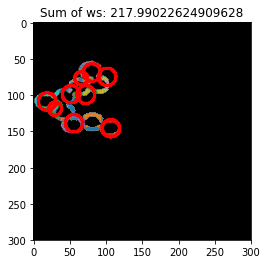

In [22]:
IRLS_ = {'sig':1,
         'isGoodth':500,
        'fitting_scope': 1.4,
        'box_ratio':(1,1),
         'minKps':50
         }

RANSAC_ = {
    'th':5,
    'lamb':40,
    'box_ratio':(1,1),
    'plot':False
}

parameters = {'RANSAC_':RANSAC_,'IRLS_':IRLS_}

i=10
mask = S[i].copy()
nn = n[i].copy()

circ = RobustFittingCircle(**parameters)
circ.fit(mask,nn)

In [24]:
import pickle
f = open('data/coin_data/edgels.pickle','wb')
data = pickle.dump(S[i].copy(),f)
f.close()

In [44]:
ek = np.append(10*np.random.randn(10),100*np.random.randn(3))
sig = 1
w = sig**2/(ek**2+sig**2)**2

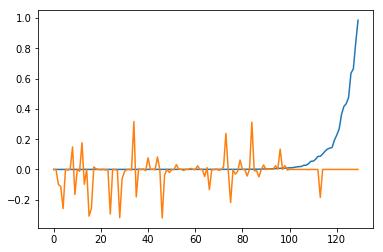

In [43]:
plt.plot(np.sort(w))
plt.plot(ek*w)

"""Parameters"""
"""
RANSAC:
        th
        lamb
        ratio
GM-Mclure:
        sig
        fitting_Scope
        fitting_box_ratio (h,w)
General:
        mimKps
"""

sig = 1
isGoodth = 500
fitting_scope = 1.4
box_ratio = (1,1)
for i in range(1):
    plt.figure(figsize=(10,16))
    mask = S[i].copy()
    nn = n[i].copy()

    nCircles = 0
    nKps=1000
    count2 = 0
    while nKps>50:
        gotcha = False
        count1 = 0
        while gotcha == False:  
            try:
                circles = random_cirles_from_edgels(mask,nn,th=30,lamb=40,ratio=(1,1)) 
                nKps = circles.kps.shape[1]

                _ = RANSAC(circles,plot=False)

                bp = CircleBestProposal(mask,kps=circles.kps_bkup,sig=sig)
                bp.fit(circles.saved)

                xk,r = bp.circles['circles'][-1]
                box_kps,_ = get_box(xk,fitting_scope*r,circles.kps_bkup,ratio=box_ratio,mask=mask,plot=False)

                circle = circle_fitting(mask,box_kps,sig=sig,p=bp.p)
                circle.fit_irls()

                gotcha = isGoodCircle(circle,isGoodth)
                count1+=1
                if count1>20:
                    #print("count1 break")
                    break
            except:
                count1+=1
                if count1>20:
                    #print("count1 break")
                    break
                continue

        
        if gotcha:
            nCircles+=1
            
            #bp.plot()
            circle.plot()

            mask = remove_support(mask,circles.kps,bp.circles['inliers'][-1])
        else:
            count2+=1

        if count2>4:
            #print("count2 break")
            break

    plt.title("Fig:%d nCircles: %d"%(i,nCircles))
    plt.imshow(S[i],**{"cmap":"gray"})   
    plt.show()
